In [16]:
import torch
class ScaledConjugateGradient(torch.optim.Optimizer):
    def __init__(self, params, sigma=1e-4, lambda_=1e-6, lambdaHAT=0, N=10):
        params = list(params) 
        if len(params) == 0:
            raise ValueError("No parameters were passed to the optimizer.")
        defaults = {'sigma': sigma, 'lambda': lambda_, 'lambdaHAT': lambdaHAT, 'N': N}
        super(ScaledConjugateGradient, self).__init__(params, defaults)
        self.k = 1
        self.sigma = sigma
        self.N = sum(p.numel() for p in params)
        self.state = {}
        flattened_params = self.flattendTheModelParameters()
        self.state['rHat'] = torch.zeros_like(flattened_params)
        self.state['pHat'] = torch.zeros_like(flattened_params)
        self.state['lambda'] = lambda_
        self.state['lambdaHAT'] = lambdaHAT
        self.state['delta_k'] = 0
        self.state['success'] = True

    def flattendTheModelParameters(self):
        params = []
        for group in self.param_groups:
            for p in group['params']:
                if p.requires_grad:
                    params.append(p.view(-1))  
        return torch.cat(params) 

    def reshapeModelParams(self, flattened_params):
        offset = 0
        for group in self.param_groups:
            for p in group['params']:
                numel = p.numel() 
                p.data.copy_(flattened_params[offset:offset + numel].view_as(p))
                offset += numel

    def computeTheModelGradients(self, closure):
        loss = closure()
        flattened_grad = self.flattendTheModelGradients()
        return loss, flattened_grad

    def flattendTheModelGradients(self):
        grads = []
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    grads.append(p.grad.view(-1)) 
        return torch.cat(grads) 

    def step(self, closure=None):
        state = self.state
        N = self.N
        loss, grad = self.computeTheModelGradients(closure)
        state['rHat'].copy_(-grad)  
        state['pHat'].copy_(state['rHat'])
        pHat_norm = torch.norm(state['pHat'])
        if state['success'] == True:
            sigma_k = self.sigma / pHat_norm
            old_params = self.flattendTheModelParameters()
            new_params = self.flattendTheModelParameters() + sigma_k * state['pHat']
            self.reshapeModelParams(new_params)
            new_loss, new_grad = self.computeTheModelGradients(closure)
            self.reshapeModelParams(old_params)
            s_k = (new_grad - grad) / sigma_k
            delta_k = torch.dot(state['pHat'], s_k)
            state['delta_k'] = delta_k  
        state['delta_k'] = state['delta_k'] + (state['lambda'] - state['lambdaHAT']) * (pHat_norm**2)
        if state['delta_k'] <= 0:
            state['lambdaHAT'] = 2 * (state['lambda'] - (state['delta_k'] /pHat_norm**2))
            state['delta_k'] = -state['delta_k'] + state['lambda'] * pHat_norm**2
            state['lambda'] = state['lambdaHAT']
        mu_k = torch.dot(state['pHat'], state['rHat'])
        alpha_k = mu_k / state['delta_k'] + 1e-10
        old_params = self.flattendTheModelParameters()
        new_params = self.flattendTheModelParameters() + alpha_k * state['pHat']
        self.reshapeModelParams(new_params)
        new_loss, new_grad = self.computeTheModelGradients(closure)
        self.reshapeModelParams(old_params)
        delta_k_placeholder = 2 * state['delta_k'] * (loss - new_loss) / (mu_k**2)
        old_rHat = state['rHat']
        if delta_k_placeholder >= 0:
            self.reshapeModelParams(new_params)
            state['rHat'] = -new_grad
            state['lambdaHAT'] = 0
            state['success'] = True
            if self.k % N == 0:
                state['pHat'] = state['rHat']
            else:
                beta_k = (torch.norm(state['rHat'])**2 - torch.dot(state['rHat'], old_rHat))/mu_k
                state['pHat'] = state['rHat'] + beta_k*state['pHat']
            if delta_k_placeholder >= 0.75:
                state['lambda'] /= 4
        else:
            state['lambdaHAT'] = state['lambda']
            state['success'] = False
        if delta_k_placeholder < 0.25:
            state['lambda'] += (state['delta_k'] * (1 - delta_k_placeholder)/ pHat_norm**2)
        if torch.allclose(old_rHat, torch.zeros_like(old_rHat)):
            return loss
        else:
            self.k +=1

In [17]:
import numpy as np
import torch
import math
import torch.nn as nn

class LeapFrogOptimizer:
  def __init__(self, model, loss_function, dt, delta, epsilon, DeltaOne, m, max_iteration):
    self.model = model
    self.s = 1
    self.p = 1
    self.x = torch.cat([p.detach().clone().flatten() for p in model.parameters()])
    self.x_prev = self.x.clone() 
    self.x_next = self.x.clone() 
    self.a = torch.zeros(param_size)       
    self.x_next_next = self.x.clone() 
    self.loss_function = loss_function 
    self.k = -1
    self.dt = dt 
    self.a_next = torch.zeros(param_size) 
    self.delta = delta 
    self.epsilon = epsilon
    self.m = m 
    self.DeltaOne = DeltaOne
    self.max_iteration = max_iteration 
    self.v = torch.zeros(param_size)    
    self.i = 0
    self.j = 2
 
    param_size = self.x.size(0)
    self.v_prev = torch.zeros(param_size) 
    self.v_next = torch.zeros(param_size)

  def calculateGradientsofParams(self, X, y):
      self.model.zero_grad() 
      predictions = self.model(X) 
      loss = self.loss_function(predictions, y)
      loss.backward() 
      gradients = -torch.cat([p.grad.clone().flatten() for p in self.model.parameters()])

      return gradients

  def step(self, X, y):
    self.a = self.calculateGradientsofParams(X, y)
    self.v = 0.5 * self.a * self.dt

    while self.k < self.max_iteration:
      self.k += 1
      dx_norm = torch.norm(self.v) * self.dt
      if dx_norm < self.delta:                             
        self.p += self.DeltaOne 
        self.dt *= self.p
      else:
        self.v = (self.delta * self.v)/(self.dt * torch.norm(self.v))

      if self.s >= self.m:                                    
        self.dt /= 2 
        self.x = (self.x + self.x_prev)/2
        self.v = (self.v + self.v_prev)/4
        self.s = 0
      self.x_next = self.x + (self.v * self.dt)
             
      with torch.no_grad():
            predictions = self.model(X)
            current_loss = self.loss_function(predictions, y)
            print(f'Epoch {self.k}, Loss: {current_loss.item()}')
      while True:
        with torch.no_grad():
            start_idx = 0
            for param in self.model.parameters():
              param_size = param.numel()
              end_idx = start_idx + param_size
              param_values = self.x_next[start_idx:end_idx].reshape(param.shape)
              param.copy_(param_values)
              start_idx = end_idx
        self.a_next = self.calculateGradientsofParams(X, y)
        self.v_next = self.v + self.a_next * self.dt
        if torch.dot(self.a_next, self.a) > 0:
          self.s = 0
        else:
          self.s += 1
          self.p = 1

        if torch.norm(self.a_next) <= self.epsilon:
          print("Optimization converged.")
          return

        if torch.norm(self.v_next) > torch.norm(self.v):
          self.i = 0
          break
        else:
          self.x_next_next = (self.x_next + self.x)/2
          self.i += 1 

        if self.i <= self.j:
          self.v_next = (self.v_next + self.v)/4
          self.k += 1 
        else:
          self.v_next = torch.zeros_like(self.v)
          self.j = 1
          self.k += 1
        if torch.norm(self.v_next) > torch.norm(self.v):
          break
      
        self.x_prev = self.x.clone()
        self.x = self.x_next.clone()
        self.x_next = self.x_next_next.clone()
        self.v_prev = self.v.clone()
        self.v = self.v_next.clone()
        self.a = self.a_next.clone()
   
      self.x_prev = self.x.clone()
      self.x = self.x_next.clone()
      self.x_next = self.x_next_next.clone()
      self.v_prev = self.v.clone()
      self.v = self.v_next.clone()
      self.a = self.a_next.clone()

In [18]:
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix

Using device: cuda
Fitting 10 folds for each of 6 candidates, totalling 60 fits


c:\Users\Chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Optimal parameters: {'hidden_size': 3, 'lr': 0.1}
Best accuracy score: 0.9545454545454545
   param_hidden_size  param_lr  mean_test_score
0                  1       0.1         0.739394
1                  3       0.1         0.954545
2                  5       0.1         0.954545
3                  8       0.1         0.954545
4                 16       0.1         0.945455
5                 32       0.1         0.946212
Test set accuracy: 0.9210526315789473
Confusion Matrix (Test Set):
[[12  0  0]
 [ 0 12  1]
 [ 0  2 11]]


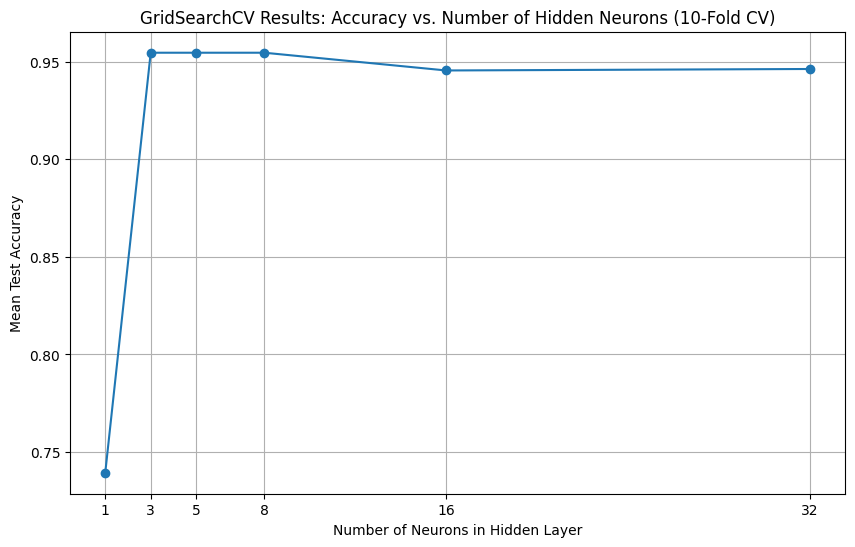

In [34]:
import torch
import torch.nn as nn
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

np.random.seed(42)
torch.manual_seed(42)


iris = load_iris()
X = iris.data
y = iris.target  


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=3):  
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.hidden(x))  
        x = self.output(x)  
        return x


class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size=4, hidden_size=1, output_size=3, epochs=5, batch_size=32, lr=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.device = device
        self.model = None  

    def fit(self, X, y):
        
        self.model = SimpleNN(self.input_size, self.hidden_size, self.output_size).to(self.device)
        dataset = TensorDataset(torch.tensor(X, dtype=torch.float32).to(self.device),
                                torch.tensor(y, dtype=torch.long).to(self.device))  
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        optimizer = Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()  

        self.model.train()
        for epoch in range(self.epochs):
            for batch_x, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = self.model(batch_x)  
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        
        self.classes_ = np.unique(y)

        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            outputs = self.model(X_tensor)  
            predicted = torch.argmax(outputs, dim=1).cpu().numpy()  
            return predicted


X_train_np = X_train_standardized
y_train_np = y_train  


param_grid = {
    'hidden_size': [1, 3, 5, 8, 16, 32],  
    'lr': [0.1],                
}


from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=PyTorchClassifier(input_size=4, output_size=3, epochs=100, batch_size=128),
    param_grid=param_grid,
    scoring='accuracy',
    cv=10, verbose=2, n_jobs=-1,
    error_score='raise'  
)


grid_search.fit(X_train_np, y_train_np)


optimal_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Optimal parameters: {optimal_params}")
print(f"Best accuracy score: {best_score}")


results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_hidden_size', 'param_lr', 'mean_test_score']])


best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test_standardized)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test set accuracy: {test_accuracy}")


from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):")
print(conf_matrix)


plt.figure(figsize=(10, 6))
plt.plot(results_df['param_hidden_size'], results_df['mean_test_score'], marker='o', linestyle='-')
plt.title('GridSearchCV Results: Accuracy vs. Number of Hidden Neurons (10-Fold CV)')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('Mean Test Accuracy')
plt.xticks(results_df['param_hidden_size'])
plt.grid(True)
plt.show()

128 neurons

----

In [36]:
import torch
import torch.nn as nn
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.optim import SGD
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

np.random.seed(42)
torch.manual_seed(42)


iris = load_iris()
X_data = iris.data
y_data = iris.target  


from sklearn.utils import shuffle
X_data, y_data = shuffle(X_data, y_data, random_state=42)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.25, random_state=42, stratify=y_data
)


scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=3):  
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.hidden(x))  
        x = self.output(x)  
        return x


class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(
        self, input_size=4, hidden_size=5, output_size=3, epochs=5, batch_size=32, lr=0.01, momentum=0
    ):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.momentum = momentum
        self.device = device
        self.model = None  

    def fit(self, X, y):
        
        self.model = SimpleNN(self.input_size, self.hidden_size, self.output_size).to(self.device)
        dataset = TensorDataset(
            torch.tensor(X, dtype=torch.float32).to(self.device),
            torch.tensor(y, dtype=torch.long).to(self.device),  
        )
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        optimizer = SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum)
        criterion = nn.CrossEntropyLoss()  

        self.model.train()
        for epoch in range(self.epochs):
            for batch_x, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = self.model(batch_x)  
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        
        self.classes_ = np.unique(y)

        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            outputs = self.model(X_tensor)  
            predicted = torch.argmax(outputs, dim=1).cpu().numpy()  
            return predicted


X_train_np = X_train_standardized
y_train_np = y_train


param_grid = {
    'lr': [0.001, 0.01, 0.1],       
    'momentum': [0.1, 0.5, 0.9],    
}


from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=PyTorchClassifier(input_size=4, hidden_size=3, epochs=10, batch_size=1),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1,
    error_score='raise',  
)


grid_search.fit(X_train_np, y_train_np)


optimal_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Optimal parameters: {optimal_params}")
print(f"Best cross-validation accuracy: {best_score}")


results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_lr', 'param_momentum', 'mean_test_score']])


best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test_standardized)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test set accuracy: {test_accuracy}")


from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):")
print(conf_matrix)


Using device: cuda
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Optimal parameters: {'lr': 0.01, 'momentum': 0.5}
Best cross-validation accuracy: 0.9553359683794467
   param_lr  param_momentum  mean_test_score
0     0.001             0.1         0.597628
1     0.001             0.5         0.624506
2     0.001             0.9         0.875099
3     0.010             0.1         0.893676
4     0.010             0.5         0.955336
5     0.010             0.9         0.955336
6     0.100             0.1         0.954941
7     0.100             0.5         0.955336
8     0.100             0.9         0.749012
Test set accuracy: 0.868421052631579
Confusion Matrix (Test Set):
[[12  0  0]
 [ 0 10  3]
 [ 0  2 11]]


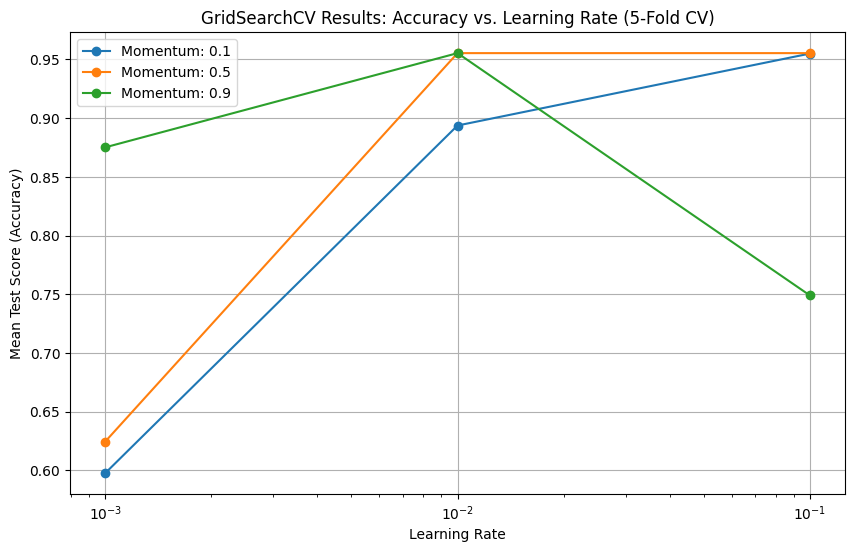

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'param_lr': [0.001, 0.001, 0.001, 0.010, 0.010, 0.010, 0.100, 0.100, 0.100],
    'param_momentum': [0.1, 0.5, 0.9, 0.1, 0.5, 0.9, 0.1, 0.5, 0.9],
    'mean_test_score': [0.597628, 0.624506, 0.875099, 0.893676, 0.955336, 0.955336, 0.954941, 0.955336, 0.749012]
}


results_df = pd.DataFrame(data)


plt.figure(figsize=(10, 6))
for momentum in [0.1, 0.5, 0.9]:
    subset = results_df[results_df['param_momentum'] == momentum]
    plt.plot(subset['param_lr'], subset['mean_test_score'], marker='o', linestyle='-', label=f'Momentum: {momentum}')


plt.title('GridSearchCV Results: Accuracy vs. Learning Rate (5-Fold CV)')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Test Score (Accuracy)')
plt.xscale('log')
plt.legend()
plt.grid(True)


plt.show()


Using device: cuda

Training fold 1/10...
Epoch 1/10, Training Loss: 0.879337
Epoch 2/10, Training Loss: 0.626615
Epoch 3/10, Training Loss: 0.521880
Epoch 4/10, Training Loss: 0.461192
Epoch 5/10, Training Loss: 0.419324
Epoch 6/10, Training Loss: 0.385438
Epoch 7/10, Training Loss: 0.358156
Epoch 8/10, Training Loss: 0.331537
Epoch 9/10, Training Loss: 0.306645
Epoch 10/10, Training Loss: 0.277583
Fold 1 - Test Accuracy: 0.9167, Training Time: 1.77 seconds

Training fold 2/10...
Epoch 1/10, Training Loss: 1.061446
Epoch 2/10, Training Loss: 0.665379
Epoch 3/10, Training Loss: 0.520392
Epoch 4/10, Training Loss: 0.450540
Epoch 5/10, Training Loss: 0.404413
Epoch 6/10, Training Loss: 0.364730
Epoch 7/10, Training Loss: 0.329002
Epoch 8/10, Training Loss: 0.294365
Epoch 9/10, Training Loss: 0.262847
Epoch 10/10, Training Loss: 0.231262
Fold 2 - Test Accuracy: 1.0000, Training Time: 1.79 seconds

Training fold 3/10...
Epoch 1/10, Training Loss: 0.854708
Epoch 2/10, Training Loss: 0.57181

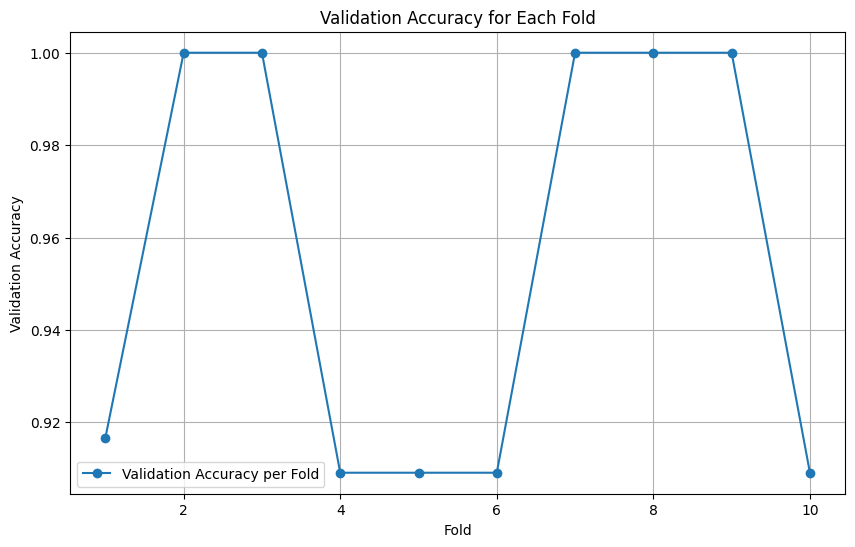

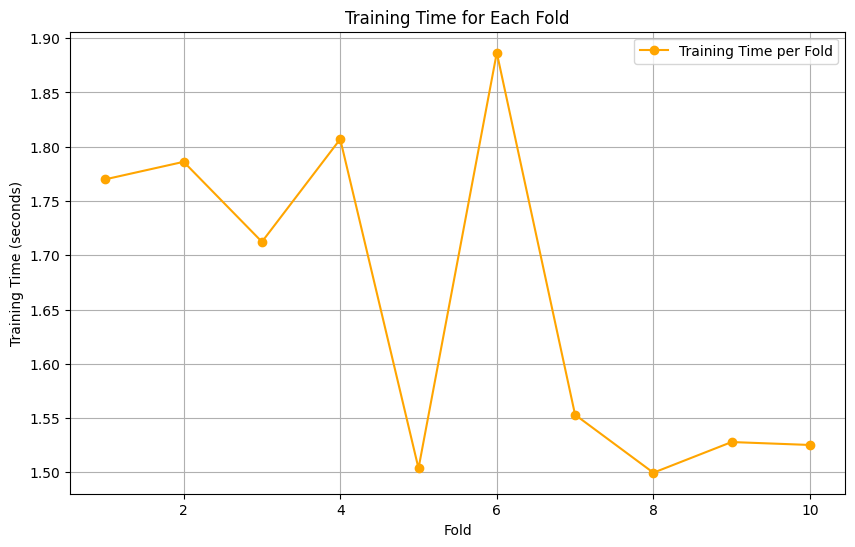

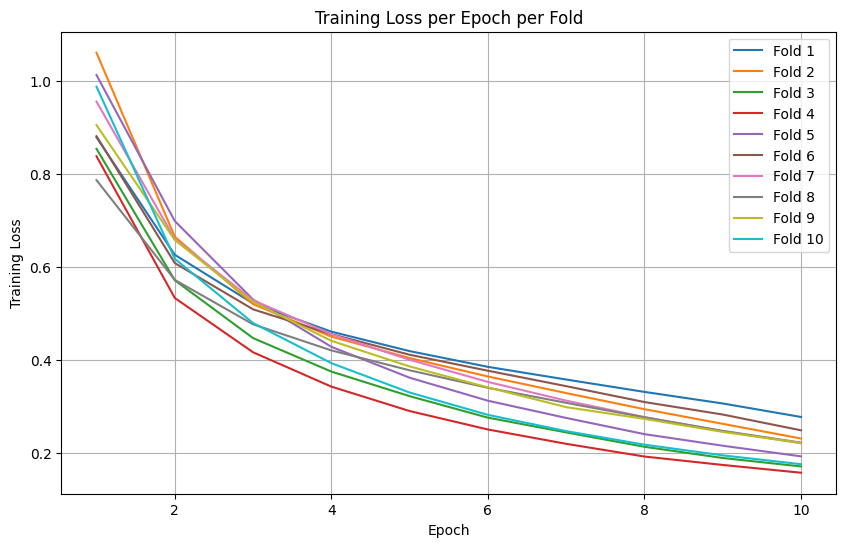

Epoch 1/10, Training Loss: 0.902789
Epoch 2/10, Training Loss: 0.581280
Epoch 3/10, Training Loss: 0.444701
Epoch 4/10, Training Loss: 0.362827
Epoch 5/10, Training Loss: 0.307802
Epoch 6/10, Training Loss: 0.262466
Epoch 7/10, Training Loss: 0.227303
Epoch 8/10, Training Loss: 0.201364
Epoch 9/10, Training Loss: 0.176047
Epoch 10/10, Training Loss: 0.159476
Test set accuracy: 0.9474
Confusion Matrix (Test Set):
[[12  0  0]
 [ 0 12  1]
 [ 0  1 12]]


In [72]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

np.random.seed(42)
torch.manual_seed(42)


iris = load_iris()
X_data = iris.data
y_data = iris.target  


from sklearn.utils import shuffle
X_data, y_data = shuffle(X_data, y_data, random_state=42)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.25, random_state=42, stratify=y_data
)


scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=3):  
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.hidden(x))  
        x = self.output(x)             
        return x


class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size=4, hidden_size=5, output_size=3, epochs=5, batch_size=32, lr=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.device = device
        self.model = None  

    def fit(self, X, y):
        
        self.model = SimpleNN(self.input_size, self.hidden_size, self.output_size).to(self.device)
        dataset = TensorDataset(torch.tensor(X, dtype=torch.float32).to(self.device),
                                torch.tensor(y, dtype=torch.long).to(self.device))  
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.5)
        criterion = nn.CrossEntropyLoss()  

        self.model.train()
        self.train_losses = []  
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            for batch_x, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item() * batch_x.size(0)  
            epoch_loss /= len(dataset)  
            self.train_losses.append(epoch_loss)
            print(f"Epoch {epoch+1}/{self.epochs}, Training Loss: {epoch_loss:.6f}")
        
        
        self.classes_ = np.unique(y)
        
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            outputs = self.model(X_tensor)
            predicted = torch.argmax(outputs, dim=1).cpu().numpy()
            return predicted


def cross_validate_model(X, y, num_folds=10, epochs=5, batch_size=32, lr=0.01):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_results = []
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nTraining fold {fold+1}/{num_folds}...")
        
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        
        model = PyTorchClassifier(input_size=4, hidden_size=3, output_size=3, epochs=epochs, batch_size=batch_size, lr=lr)

        
        start_time = time.time()

        
        model.fit(X_train_fold, y_train_fold)

        
        training_time = time.time() - start_time

        
        y_test_pred = model.predict(X_test_fold)
        test_accuracy = accuracy_score(y_test_fold, y_test_pred)

        
        fold_results.append({
            'fold': fold + 1,
            'test_accuracy': test_accuracy,
            'training_time': training_time,
            'train_losses': model.train_losses
        })

        print(f"Fold {fold+1} - Test Accuracy: {test_accuracy:.4f}, Training Time: {training_time:.2f} seconds")

    return fold_results


cross_val_results = cross_validate_model(
    X_train_standardized, y_train, num_folds=10, epochs=10, batch_size=1, lr=0.01
)


cross_val_df_sgd = pd.DataFrame(cross_val_results)
print("\nCross-Validation Results:")
print(cross_val_df_sgd[['fold', 'test_accuracy', 'training_time']])


val_accuracies = cross_val_df_sgd['test_accuracy']
plt.figure(figsize=(10,6))
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, marker='o', label='Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Each Fold')
plt.grid(True)
plt.legend()
plt.show()


training_times = cross_val_df_sgd['training_time']
plt.figure(figsize=(10,6))
plt.plot(range(1, len(training_times)+1), training_times, marker='o', color='orange', label='Training Time per Fold')
plt.xlabel('Fold')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Each Fold')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(10,6))
for i, fold_result in enumerate(cross_val_results):
    train_losses = fold_result['train_losses']
    plt.plot(range(1, len(train_losses)+1), train_losses, label=f'Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch per Fold')
plt.legend()
plt.grid(True)
plt.show()


final_model = PyTorchClassifier(input_size=4, hidden_size=3, output_size=3, epochs=10, batch_size=1, lr=0.01)
final_model.fit(X_train_standardized, y_train)

y_test_pred = final_model.predict(X_test_standardized)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test set accuracy: {test_accuracy:.4f}")


from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):")
print(conf_matrix)


Using device: cuda

Training fold 1/10...
Epoch 1/10, Training Loss: 0.610341
Epoch 2/10, Training Loss: 0.453700
Epoch 3/10, Training Loss: 0.404345
Epoch 4/10, Training Loss: 0.358761
Epoch 5/10, Training Loss: 0.328006
Epoch 6/10, Training Loss: 0.293147
Epoch 7/10, Training Loss: 0.267594
Epoch 8/10, Training Loss: 0.224316
Epoch 9/10, Training Loss: 0.224316
Epoch 10/10, Training Loss: 0.184363
Fold 1 - Validation Accuracy: 1.0000, Training Time: 0.15 seconds

Training fold 2/10...
Epoch 1/10, Training Loss: 0.648397
Epoch 2/10, Training Loss: 0.467893
Epoch 3/10, Training Loss: 0.383325
Epoch 4/10, Training Loss: 0.320216
Epoch 5/10, Training Loss: 0.281746
Epoch 6/10, Training Loss: 0.252615
Epoch 7/10, Training Loss: 0.223313
Epoch 8/10, Training Loss: 0.203746
Epoch 9/10, Training Loss: 0.157089
Epoch 10/10, Training Loss: 0.139535
Fold 2 - Validation Accuracy: 0.9167, Training Time: 0.09 seconds

Training fold 3/10...
Epoch 1/10, Training Loss: 1.424456
Epoch 2/10, Training L

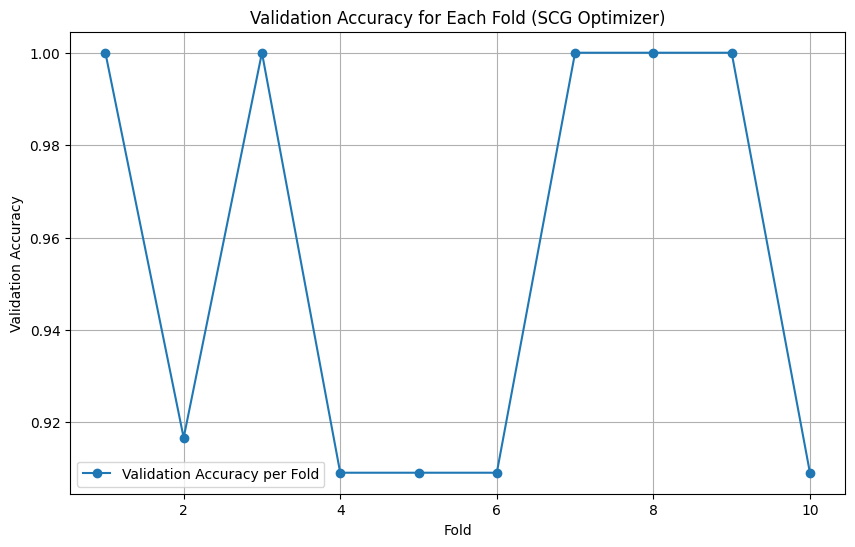

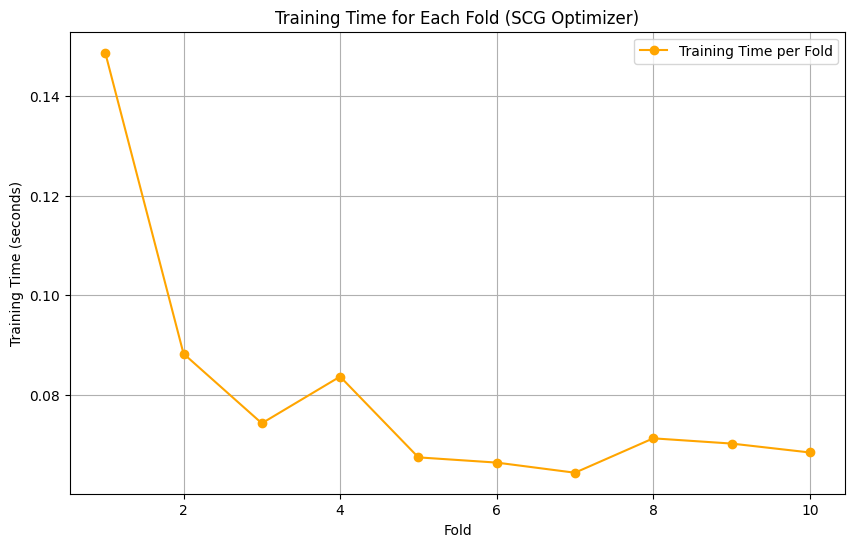

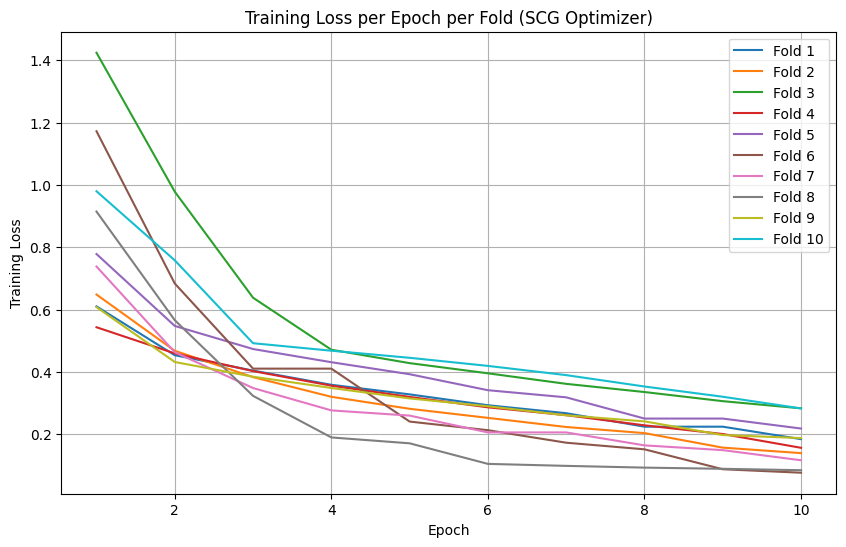

Epoch 1/5, Training Loss: 0.622750
Epoch 2/5, Training Loss: 0.444956
Epoch 3/5, Training Loss: 0.396135
Epoch 4/5, Training Loss: 0.362172
Epoch 5/5, Training Loss: 0.335183
Test set accuracy: 0.8158
Confusion Matrix (Test Set):
[[12  0  0]
 [ 0  7  6]
 [ 0  1 12]]


In [39]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import time
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris





device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

np.random.seed(42)
torch.manual_seed(42)


iris = load_iris()
X_data = iris.data
y_data = iris.target  


from sklearn.utils import shuffle
X_data, y_data = shuffle(X_data, y_data, random_state=42)


from sklearn.model_selection import train_test_split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_data, y_data, test_size=0.25, random_state=42, stratify=y_data
)


scaler = StandardScaler()
X_train_full_standardized = scaler.fit_transform(X_train_full)
X_test_standardized = scaler.transform(X_test)


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=3):  
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.hidden(x))  
        x = self.output(x)             
        return x


class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size=4, hidden_size=5, output_size=3, epochs=5):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.epochs = epochs
        self.device = device
        self.model = None  

    def fit(self, X, y):
        
        self.model = SimpleNN(self.input_size, self.hidden_size, self.output_size).to(self.device)
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.long).to(self.device)

        criterion = nn.CrossEntropyLoss()  

        self.model.train()
        self.train_losses = []  

        
        def closure():
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            return loss

        
        optimizer = ScaledConjugateGradient(self.model.parameters())

        for epoch in range(self.epochs):
            loss = optimizer.step(closure)
            train_loss = criterion(self.model(X_tensor), y_tensor).item()
            self.train_losses.append(train_loss)
            print(f"Epoch {epoch+1}/{self.epochs}, Training Loss: {train_loss:.6f}")

        
        self.classes_ = np.unique(y)

        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            outputs = self.model(X_tensor)  
            predicted = torch.argmax(outputs, dim=1).cpu().numpy()  
            return predicted


X_train_np = X_train_full_standardized
y_train_np = y_train_full


import time


def cross_validate_model(X, y, num_folds=5, epochs=5):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_results = []
    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        print(f"\nTraining fold {fold+1}/{num_folds}...")
        
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        
        model = PyTorchClassifier(input_size=4, hidden_size=3, epochs=epochs)

        
        start_time = time.time()

        
        model.fit(X_train_fold, y_train_fold)

        
        training_time = time.time() - start_time

        
        y_val_pred = model.predict(X_val_fold)
        val_accuracy = accuracy_score(y_val_fold, y_val_pred)

        
        fold_results.append({
            'fold': fold + 1,
            'val_accuracy': val_accuracy,
            'training_time': training_time,
            'train_losses': model.train_losses
        })

        print(f"Fold {fold+1} - Validation Accuracy: {val_accuracy:.4f}, Training Time: {training_time:.2f} seconds")

    return fold_results


cross_val_results = cross_validate_model(
    X_train_np, y_train_np, num_folds=10, epochs=10
)


cross_val_df_scg = pd.DataFrame(cross_val_results)
print("\nCross-Validation Results:")
print(cross_val_df_scg[['fold', 'val_accuracy', 'training_time']])


val_accuracies = cross_val_df_scg['val_accuracy']
plt.figure(figsize=(10,6))
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, marker='o', label='Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Each Fold (SCG Optimizer)')
plt.grid(True)
plt.legend()
plt.show()


training_times = cross_val_df_scg['training_time']
plt.figure(figsize=(10,6))
plt.plot(range(1, len(training_times)+1), training_times, marker='o', color='orange', label='Training Time per Fold')
plt.xlabel('Fold')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Each Fold (SCG Optimizer)')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(10,6))
for i, fold_result in enumerate(cross_val_results):
    train_losses = fold_result['train_losses']
    plt.plot(range(1, len(train_losses)+1), train_losses, label=f'Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch per Fold (SCG Optimizer)')
plt.legend()
plt.grid(True)
plt.show()


final_model = PyTorchClassifier(input_size=4, hidden_size=5, epochs=5)
final_model.fit(X_train_np, y_train_np)

y_test_pred = final_model.predict(X_test_standardized)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test set accuracy: {test_accuracy:.4f}")


from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):")
print(conf_matrix)


---

Using device: cuda

Training fold 1/10...
Epoch 0, Loss: 1.0977776050567627
Epoch 1, Loss: 1.0538641214370728
Epoch 2, Loss: 0.910051703453064
Epoch 3, Loss: 0.6909936666488647
Epoch 4, Loss: 0.5116374492645264
Epoch 5, Loss: 0.4356740117073059
Epoch 6, Loss: 0.3484276831150055
Epoch 7, Loss: 0.3012799620628357
Epoch 8, Loss: 0.2612074613571167
Epoch 9, Loss: 0.21801117062568665
Epoch 10, Loss: 0.1505861133337021
Epoch 1/10, Training Loss: 0.085509
Epoch 2/10, Training Loss: 0.085509
Epoch 3/10, Training Loss: 0.085509
Epoch 4/10, Training Loss: 0.085509
Epoch 5/10, Training Loss: 0.085509
Epoch 6/10, Training Loss: 0.085509
Epoch 7/10, Training Loss: 0.085509
Epoch 8/10, Training Loss: 0.085509
Epoch 9/10, Training Loss: 0.085509
Epoch 10/10, Training Loss: 0.085509
Fold 1 - Validation Accuracy: 0.9167, Training Time: 0.08 seconds

Training fold 2/10...
Epoch 0, Loss: 1.1834274530410767
Epoch 1, Loss: 1.116916537284851
Epoch 2, Loss: 0.9113699197769165
Epoch 3, Loss: 0.666518390178680

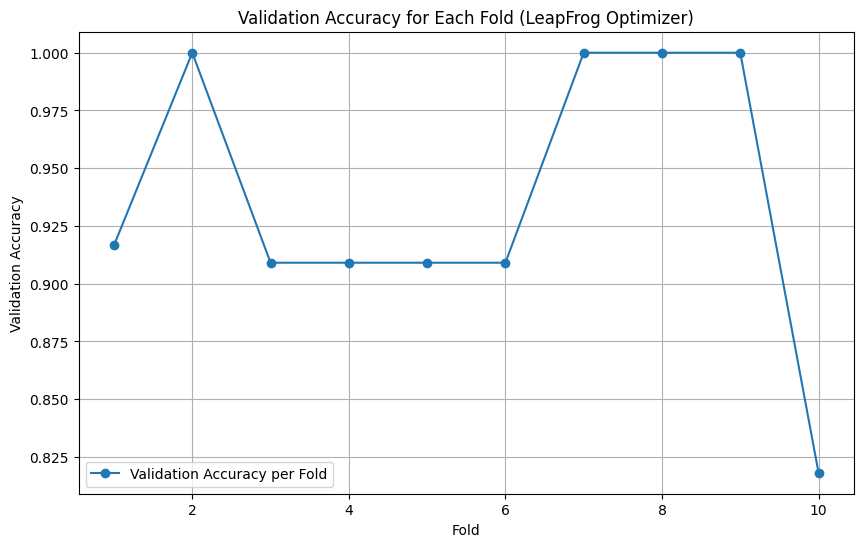

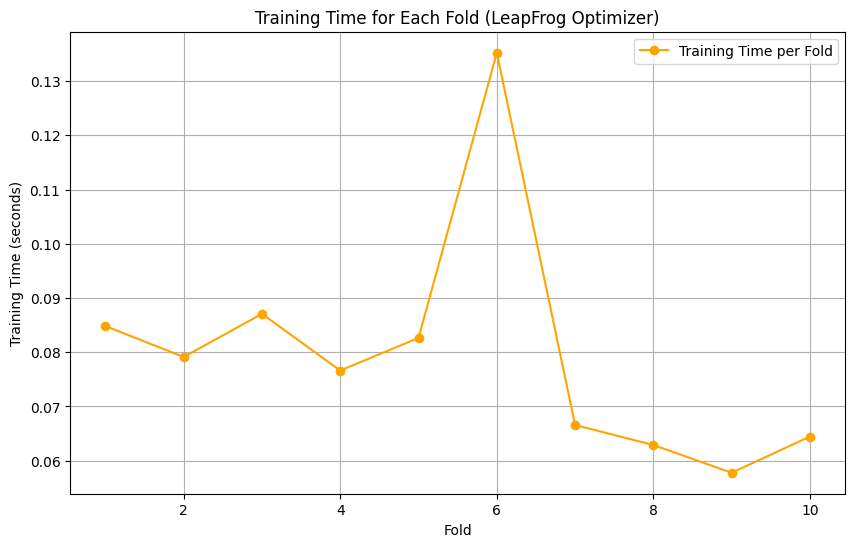

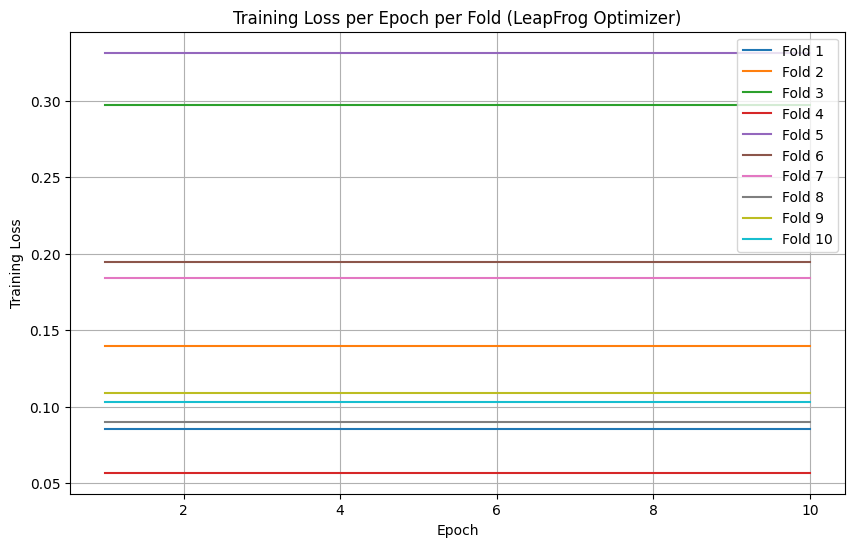

Epoch 0, Loss: 1.0036990642547607
Epoch 1, Loss: 0.9719249606132507
Epoch 2, Loss: 0.861165463924408
Epoch 3, Loss: 0.672162652015686
Epoch 4, Loss: 0.5196928977966309
Epoch 5, Loss: 0.4325580894947052
Epoch 6, Loss: 0.35088321566581726
Epoch 7, Loss: 0.33088207244873047
Epoch 8, Loss: 0.25280576944351196
Epoch 9, Loss: 0.22131085395812988
Epoch 10, Loss: 0.1735612004995346
Epoch 1/10, Training Loss: 0.109463
Epoch 2/10, Training Loss: 0.109463
Epoch 3/10, Training Loss: 0.109463
Epoch 4/10, Training Loss: 0.109463
Epoch 5/10, Training Loss: 0.109463
Epoch 6/10, Training Loss: 0.109463
Epoch 7/10, Training Loss: 0.109463
Epoch 8/10, Training Loss: 0.109463
Epoch 9/10, Training Loss: 0.109463
Epoch 10/10, Training Loss: 0.109463
Test set accuracy: 0.8947
Confusion Matrix (Test Set):
[[12  0  0]
 [ 0 11  2]
 [ 0  2 11]]


In [42]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import time
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

np.random.seed(42)
torch.manual_seed(42)


iris = load_iris()
X_data = iris.data
y_data = iris.target  

from sklearn.utils import shuffle
X_data, y_data = shuffle(X_data, y_data, random_state=42)


from sklearn.model_selection import train_test_split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_data, y_data, test_size=0.25, random_state=42, stratify=y_data
)


scaler = StandardScaler()
X_train_full_standardized = scaler.fit_transform(X_train_full)
X_test_standardized = scaler.transform(X_test)


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=3):  
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.hidden(x))  
        x = self.output(x)             
        return x


class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size=4, hidden_size=5, output_size=3, epochs=5):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.epochs = epochs
        self.device = device
        self.model = None  

    def fit(self, X, y):
        
        self.model = SimpleNN(self.input_size, self.hidden_size, self.output_size).to(self.device)
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.long).to(self.device)

        criterion = nn.CrossEntropyLoss()  

        self.model.train()
        self.train_losses = []  

        
        optimizer = LeapFrogOptimizer(
            self.model, criterion, dt=0.5, delta=1, epsilon=1e-7, delta1=0.1, m=3, max_iteration=self.epochs
        )

        
        start_time = time.time()

        
        for epoch in range(self.epochs):
            
            optimizer.step(X_tensor, y_tensor)

            
            outputs = self.model(X_tensor)
            loss = criterion(outputs, y_tensor)
            train_loss = loss.item()
            self.train_losses.append(train_loss)

            print(f"Epoch {epoch+1}/{self.epochs}, Training Loss: {train_loss:.6f}")

        
        training_time = time.time() - start_time
        self.training_time = training_time

        
        self.classes_ = np.unique(y)

        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            outputs = self.model(X_tensor)  
            predicted = torch.argmax(outputs, dim=1).cpu().numpy()  
            return predicted


X_train_np = X_train_full_standardized
y_train_np = y_train_full


import time


def cross_validate_model(X, y, num_folds=5, epochs=5):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_results = []
    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        print(f"\nTraining fold {fold+1}/{num_folds}...")
        
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        
        model = PyTorchClassifier(input_size=4, hidden_size=3, epochs=epochs)

        
        start_time = time.time()

        
        model.fit(X_train_fold, y_train_fold)

        
        training_time = time.time() - start_time

        
        y_val_pred = model.predict(X_val_fold)
        val_accuracy = accuracy_score(y_val_fold, y_val_pred)

        
        fold_results.append({
            'fold': fold + 1,
            'val_accuracy': val_accuracy,
            'training_time': training_time,
            'train_losses': model.train_losses
        })

        print(f"Fold {fold+1} - Validation Accuracy: {val_accuracy:.4f}, Training Time: {training_time:.2f} seconds")

    return fold_results

cross_val_results = cross_validate_model(
    X_train_np, y_train_np, num_folds=10, epochs=10
)



cross_val_df_leapFrog = pd.DataFrame(cross_val_results)
print("\nCross-Validation Results:")
print(cross_val_df_leapFrog[['fold', 'val_accuracy', 'training_time']])


val_accuracies = cross_val_df_leapFrog['val_accuracy']
plt.figure(figsize=(10,6))
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, marker='o', label='Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Each Fold (LeapFrog Optimizer)')
plt.grid(True)
plt.legend()
plt.show()


training_times = cross_val_df_leapFrog['training_time']
plt.figure(figsize=(10,6))
plt.plot(range(1, len(training_times)+1), training_times, marker='o', color='orange', label='Training Time per Fold')
plt.xlabel('Fold')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Each Fold (LeapFrog Optimizer)')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(10,6))
for i, fold_result in enumerate(cross_val_results):
    train_losses = fold_result['train_losses']
    plt.plot(range(1, len(train_losses)+1), train_losses, label=f'Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch per Fold (LeapFrog Optimizer)')
plt.legend()
plt.grid(True)
plt.show()


final_model = PyTorchClassifier(input_size=4, hidden_size=5, epochs=10)
final_model.fit(X_train_np, y_train_np)

y_test_pred = final_model.predict(X_test_standardized)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test set accuracy: {test_accuracy:.4f}")


from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):")
print(conf_matrix)


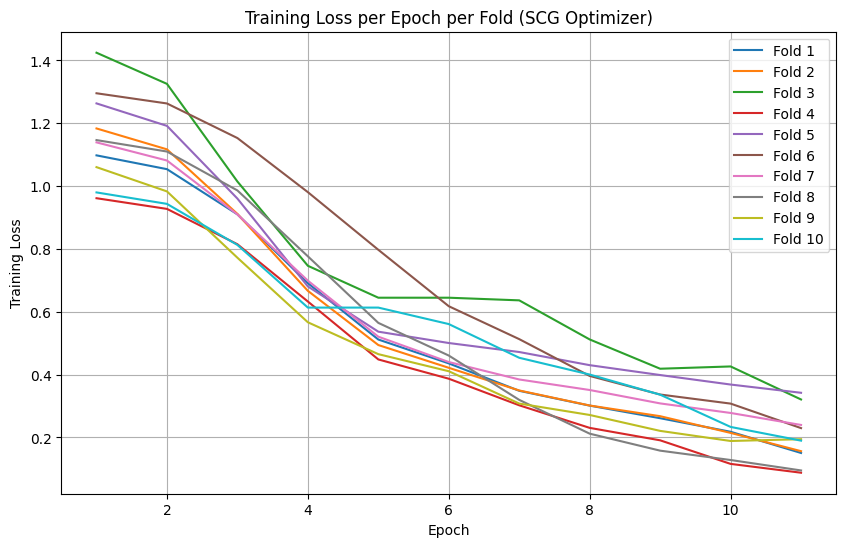

In [49]:
import pandas as pd
import re

def parse_training_log_no_nan(log_str):
    
    fold_pattern = re.compile(r"Training fold (\d+)/\d+...")
    epoch_loss_pattern = re.compile(r"Epoch (\d+), Loss: ([\d.]+)")
    
    
    results = {}
    
    current_fold = None
    max_epochs = 0  

    for line in log_str.splitlines():
        fold_match = fold_pattern.match(line)
        if fold_match:
            current_fold = int(fold_match.group(1))
            results[current_fold] = {}
        elif current_fold is not None:
            epoch_loss_match = epoch_loss_pattern.match(line)
            if epoch_loss_match:
                epoch = int(epoch_loss_match.group(1))
                loss = float(epoch_loss_match.group(2))
                results[current_fold][epoch] = loss
                max_epochs = max(max_epochs, epoch)
    
    
    for fold in results:
        last_loss = None
        for epoch in range(max_epochs + 1):
            if epoch in results[fold]:
                last_loss = results[fold][epoch]
            else:
                results[fold][epoch] = last_loss  
    
    
    df = pd.DataFrame.from_dict(results, orient='index').transpose()
    return df






log_str = """
Training fold 1/10...
Epoch 0, Loss: 1.0977776050567627
Epoch 1, Loss: 1.0538641214370728
Epoch 2, Loss: 0.910051703453064
Epoch 3, Loss: 0.6909936666488647
Epoch 4, Loss: 0.5116374492645264
Epoch 5, Loss: 0.4356740117073059
Epoch 6, Loss: 0.3484276831150055
Epoch 7, Loss: 0.3012799620628357
Epoch 8, Loss: 0.2612074613571167
Epoch 9, Loss: 0.21801117062568665
Epoch 10, Loss: 0.1505861133337021
Fold 1 - Validation Accuracy: 0.9167, Training Time: 0.08 seconds

Training fold 2/10...
Epoch 0, Loss: 1.1834274530410767
Epoch 1, Loss: 1.116916537284851
Epoch 2, Loss: 0.9113699197769165
Epoch 3, Loss: 0.6665183901786804
Epoch 4, Loss: 0.4940792918205261
Epoch 5, Loss: 0.42160481214523315
Epoch 6, Loss: 0.3495001494884491
Epoch 7, Loss: 0.301618754863739
Epoch 8, Loss: 0.26763564348220825
Epoch 9, Loss: 0.2144547998905182
Epoch 10, Loss: 0.15628689527511597
Fold 2 - Validation Accuracy: 1.0000, Training Time: 0.08 seconds

Training fold 3/10...
Epoch 0, Loss: 1.4244564771652222
Epoch 1, Loss: 1.3253200054168701
Epoch 2, Loss: 1.0144643783569336
Epoch 3, Loss: 0.7463234066963196
Epoch 4, Loss: 0.6447231769561768
Epoch 6, Loss: 0.6363115310668945
Epoch 7, Loss: 0.5118811726570129
Epoch 8, Loss: 0.4186961352825165
Epoch 9, Loss: 0.42595434188842773
Epoch 10, Loss: 0.3208200931549072
Fold 3 - Validation Accuracy: 0.9091, Training Time: 0.09 seconds

Training fold 4/10...
Epoch 0, Loss: 0.9613664150238037
Epoch 1, Loss: 0.9273985028266907
Epoch 2, Loss: 0.8148942589759827
Epoch 3, Loss: 0.6325944066047668
Epoch 4, Loss: 0.44824525713920593
Epoch 5, Loss: 0.3868964612483978
Epoch 6, Loss: 0.30230778455734253
Epoch 7, Loss: 0.23043781518936157
Epoch 8, Loss: 0.19083170592784882
Epoch 9, Loss: 0.11581473797559738
Epoch 10, Loss: 0.0877089649438858
Fold 4 - Validation Accuracy: 0.9091, Training Time: 0.08 seconds

Training fold 5/10...
Epoch 0, Loss: 1.2631529569625854
Epoch 1, Loss: 1.1916157007217407
Epoch 2, Loss: 0.9602267742156982
Epoch 3, Loss: 0.6806077361106873
Epoch 4, Loss: 0.5366324782371521
Epoch 5, Loss: 0.5005162954330444
Epoch 6, Loss: 0.4718853831291199
Epoch 7, Loss: 0.43003049492836
Epoch 8, Loss: 0.3986034095287323
Epoch 9, Loss: 0.3683697283267975
Epoch 10, Loss: 0.34212803840637207
Fold 5 - Validation Accuracy: 0.9091, Training Time: 0.08 seconds

Training fold 6/10...
Epoch 0, Loss: 1.2954139709472656
Epoch 1, Loss: 1.2629404067993164
Epoch 2, Loss: 1.152855634689331
Epoch 3, Loss: 0.9806702136993408
Epoch 4, Loss: 0.7972224950790405
Epoch 5, Loss: 0.6176302433013916
Epoch 6, Loss: 0.5128840208053589
Epoch 7, Loss: 0.3957575559616089
Epoch 8, Loss: 0.3366093337535858
Epoch 9, Loss: 0.3077017664909363
Epoch 10, Loss: 0.2297094315290451
Fold 6 - Validation Accuracy: 0.9091, Training Time: 0.14 seconds

Training fold 7/10...
Epoch 0, Loss: 1.139140248298645
Epoch 1, Loss: 1.081371545791626
Epoch 2, Loss: 0.9097049236297607
Epoch 3, Loss: 0.6989566087722778
Epoch 4, Loss: 0.5206392407417297
Epoch 5, Loss: 0.44000229239463806
Epoch 6, Loss: 0.38449493050575256
Epoch 7, Loss: 0.3509926497936249
Epoch 8, Loss: 0.308333158493042
Epoch 9, Loss: 0.27793005108833313
Epoch 10, Loss: 0.23976212739944458
Fold 7 - Validation Accuracy: 1.0000, Training Time: 0.07 seconds

Training fold 8/10...
Epoch 0, Loss: 1.146394968032837
Epoch 1, Loss: 1.1099433898925781
Epoch 2, Loss: 0.986105740070343
Epoch 3, Loss: 0.7764350771903992
Epoch 4, Loss: 0.564598023891449
Epoch 5, Loss: 0.46064358949661255
Epoch 6, Loss: 0.3195570111274719
Epoch 7, Loss: 0.21198733150959015
Epoch 8, Loss: 0.15795786678791046
Epoch 9, Loss: 0.1281731277704239
Epoch 10, Loss: 0.09496332705020905
Fold 8 - Validation Accuracy: 1.0000, Training Time: 0.06 seconds

Training fold 9/10...
Epoch 0, Loss: 1.0602869987487793
Epoch 1, Loss: 0.9830506443977356
Epoch 2, Loss: 0.7719964385032654
Epoch 3, Loss: 0.5665171146392822
Epoch 4, Loss: 0.4650948643684387
Epoch 5, Loss: 0.41075682640075684
Epoch 6, Loss: 0.30782926082611084
Epoch 7, Loss: 0.2715357840061188
Epoch 8, Loss: 0.22087302803993225
Epoch 9, Loss: 0.18871037662029266
Epoch 10, Loss: 0.19441737234592438
Fold 9 - Validation Accuracy: 1.0000, Training Time: 0.06 seconds

Training fold 10/10...
Epoch 0, Loss: 0.9798343777656555
Epoch 1, Loss: 0.9433721899986267
Epoch 2, Loss: 0.812634289264679
Epoch 3, Loss: 0.6132913827896118
Epoch 5, Loss: 0.5608338117599487
Epoch 6, Loss: 0.45354560017585754
Epoch 7, Loss: 0.4001874327659607
Epoch 8, Loss: 0.336077481508255
Epoch 9, Loss: 0.23346973955631256
Epoch 10, Loss: 0.1898137480020523
Fold 10 - Validation Accuracy: 0.8182, Training Time: 0.06 seconds

"""


df = parse_training_log_no_nan(log_str)

plt.figure(figsize=(10,6))
for fold in df.columns:
    plt.plot(range(1, len(df) + 1), df[fold], label=f'Fold {fold}')
    
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch per Fold (SCG Optimizer)')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
cross_val_df_leapFrog

,fold,val_accuracy,training_time,train_losses
0,1,0.916667,0.084834,"[0.08550859242677689, 0.08550859242677689, 0.0..."
1,2,1.000000,0.079128,"[0.1399444341659546, 0.1399444341659546, 0.139..."
2,3,0.909091,0.087087,"[0.2971287965774536, 0.2971287965774536, 0.297..."
3,4,0.909091,0.076628,"[0.056811634451150894, 0.056811634451150894, 0..."
4,5,0.909091,0.082638,"[0.33130985498428345, 0.33130985498428345, 0.3..."
5,6,0.909091,0.135242,"[0.1947207748889923, 0.1947207748889923, 0.194..."
6,7,1.000000,0.066582,"[0.18384191393852234, 0.18384191393852234, 0.1..."
7,8,1.000000,0.062895,"[0.09015993773937225, 0.09015993773937225, 0.0..."
8,9,1.000000,0.057780,"[0.10871952027082443, 0.10871952027082443, 0.1..."
9,10,0.818182,0.064445,"[0.10321760922670364, 0.10321760922670364, 0.1..."


In [56]:

cross_val_df_scg

,fold,val_accuracy,training_time,train_losses
0,1,1.000000,0.148667,"[0.6103405356407166, 0.45369982719421387, 0.40..."
1,2,0.916667,0.088248,"[0.6483969688415527, 0.4678930640220642, 0.383..."
2,3,1.000000,0.074279,"[1.4244564771652222, 0.9784570932388306, 0.638..."
3,4,0.909091,0.083653,"[0.5434306859970093, 0.4594959616661072, 0.402..."
4,5,0.909091,0.067437,"[0.7784282565116882, 0.5476201176643372, 0.473..."
5,6,0.909091,0.066389,"[1.1723979711532593, 0.6837533712387085, 0.410..."
6,7,1.000000,0.064355,"[0.7383484244346619, 0.46324053406715393, 0.34..."
7,8,1.000000,0.071258,"[0.9146589040756226, 0.5660310983657837, 0.323..."
8,9,1.000000,0.070209,"[0.6079077124595642, 0.4319080412387848, 0.384..."
9,10,0.909091,0.068420,"[0.9798343777656555, 0.7581948637962341, 0.492..."


In [73]:

cross_val_df_sgd

,fold,test_accuracy,training_time,train_losses
0,1,0.916667,1.770009,"[0.8793366929888725, 0.6266150826215744, 0.521..."
1,2,1.000000,1.786123,"[1.0614464539289474, 0.6653794395923615, 0.520..."
2,3,1.000000,1.712404,"[0.8547076848473879, 0.571812110372109, 0.4473..."
3,4,0.909091,1.807036,"[0.8386896586064065, 0.5336620456511432, 0.416..."
4,5,0.909091,1.503696,"[1.0135010073680688, 0.6991638529418719, 0.530..."
5,6,0.909091,1.886644,"[0.8818297347810009, 0.6087475231673458, 0.509..."
6,7,1.000000,1.553065,"[0.9562186218134248, 0.6604552761753006, 0.528..."
7,8,1.000000,1.499650,"[0.7871773986533137, 0.572578222444742, 0.4769..."
8,9,1.000000,1.527920,"[0.9057106535033425, 0.6584213222607528, 0.524..."
9,10,0.909091,1.525224,"[0.9884295310124313, 0.6179655369850668, 0.479..."


In [74]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.pyplot as plt

loss_leapfrog = cross_val_df_leapFrog['val_accuracy'].values
loss_scg = cross_val_df_scg['val_accuracy'].values
loss_sgd = cross_val_df_sgd['test_accuracy'].values


combined_losses = pd.DataFrame({
    'LeapFrog': loss_leapfrog,
    'SCG': loss_scg,
    'SGD': loss_sgd
})

In [75]:

statistic, p_value = friedmanchisquare(
    combined_losses['LeapFrog'],
    combined_losses['SCG'],
    combined_losses['SGD']
)

print('Friedman test statistic:', statistic)
print('p-value:', p_value)


Friedman test statistic: 2.000000000000028
p-value: 0.36787944117143734


In [76]:
if p_value < 0.05:
    print('Result: There is a statistically significant difference between the optimizers.')
else:
    print('Result: There is no statistically significant difference between the optimizers.')


Result: There is no statistically significant difference between the optimizers.


In [77]:
# Perform the Nemenyi post-hoc test
nemenyi_results = sp.posthoc_nemenyi_friedman(combined_losses.values)

# Set up the labels
nemenyi_results.columns = ['LeapFrog', 'SCG', 'SGD']
nemenyi_results.index = ['LeapFrog', 'SCG', 'SGD']

print('\nNemenyi post-hoc test p-values:')
print(nemenyi_results)



Nemenyi post-hoc test p-values:
          LeapFrog       SCG       SGD
LeapFrog  1.000000  0.759769  0.759769
SCG       0.759769  1.000000  0.900000
SGD       0.759769  0.900000  1.000000


In [78]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.pyplot as plt
from tabulate import tabulate  







loss_leapfrog = cross_val_df_leapFrog['val_accuracy'].values
loss_scg = cross_val_df_scg['val_accuracy'].values
loss_sgd = cross_val_df_sgd['test_accuracy'].values


combined_losses = pd.DataFrame({
    'LeapFrog': loss_leapfrog,
    'SCG': loss_scg,
    'SGD': loss_sgd
})


statistic, p_value = friedmanchisquare(
    combined_losses['LeapFrog'],
    combined_losses['SCG'],
    combined_losses['SGD']
)

print('Friedman test statistic:', statistic)
print('p-value:', p_value)


if p_value < 0.05:
    print('\nResult: There is a statistically significant difference between the optimizers.')

    
    nemenyi_results = sp.posthoc_nemenyi_friedman(combined_losses.values)

    
    nemenyi_results.columns = ['LeapFrog', 'SCG', 'SGD']
    nemenyi_results.index = ['LeapFrog', 'SCG', 'SGD']

    
    nemenyi_results = nemenyi_results.round(5)

    
    print('\nNemenyi post-hoc test p-values:')
    print(tabulate(nemenyi_results, headers='keys', tablefmt='grid'))
else:
    print('\nResult: There is no statistically significant difference between the optimizers.')


Friedman test statistic: 2.000000000000028
p-value: 0.36787944117143734

Result: There is no statistically significant difference between the optimizers.


In [79]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.pyplot as plt
from tabulate import tabulate  







loss_leapfrog = cross_val_df_leapFrog['val_accuracy'].values
loss_scg = cross_val_df_scg['val_accuracy'].values
loss_sgd = cross_val_df_sgd['test_accuracy'].values


combined_losses = pd.DataFrame({
    'LeapFrog': loss_leapfrog,
    'SCG': loss_scg,
    'SGD': loss_sgd
})


statistic, p_value = friedmanchisquare(
    combined_losses['LeapFrog'],
    combined_losses['SCG'],
    combined_losses['SGD']
)

print('Friedman test statistic:', statistic)
print('p-value:', p_value)

if p_value < 0.05:
    print('\nResult: There is a statistically significant difference between the optimizers.')

    
    nemenyi_results = sp.posthoc_nemenyi_friedman(combined_losses.values)

    
    optimizers = combined_losses.columns.tolist()
    nemenyi_results.columns = optimizers
    nemenyi_results.index = optimizers

    
    nemenyi_results = nemenyi_results.round(5)

    
    print('\nNemenyi post-hoc test p-values:')
    print(tabulate(nemenyi_results, headers='keys', tablefmt='grid'))

    
    print('\nInterpretation of the Table:')
    print('Diagonal Elements: The diagonal elements are all 1, as they represent comparisons of each optimizer with itself.\n')

    significant_pairs = []
    nonsignificant_pairs = []
    alpha = 0.05  

    
    for i in range(len(optimizers)):
        for j in range(i + 1, len(optimizers)):
            optimizer1 = optimizers[i]
            optimizer2 = optimizers[j]
            p_val = nemenyi_results.iloc[i, j]
            if p_val < alpha:
                significant_pairs.append((optimizer1, optimizer2, p_val))
            else:
                nonsignificant_pairs.append((optimizer1, optimizer2, p_val))

    
    if significant_pairs:
        print('Significant P-Values (p < 0.05):')
        for opt1, opt2, p_val in significant_pairs:
            print(f'- {opt1} vs. {opt2}: p = {p_val} (significant)')
    else:
        print('No significant differences found.')

    
    if nonsignificant_pairs:
        print('\nNon-Significant P-Values (p >= 0.05):')
        for opt1, opt2, p_val in nonsignificant_pairs:
            print(f'- {opt1} vs. {opt2}: p = {p_val} (not significant)')
    else:
        print('All pairs show significant differences.')

    
    plt.figure(figsize=(10, 6))
    combined_losses.boxplot()
    plt.ylabel('Loss')
    plt.title('Loss Distribution Across Optimizers')
    plt.grid(True)
    plt.show()

else:
    print('\nResult: There is no statistically significant difference between the optimizers.')


Friedman test statistic: 2.000000000000028
p-value: 0.36787944117143734

Result: There is no statistically significant difference between the optimizers.


In [81]:
import numpy as np
import pandas as pd



mean_val_losses = np.array([
    cross_val_df_sgd['test_accuracy'].mean(),
    cross_val_df_scg['val_accuracy'].mean(),
    cross_val_df_leapFrog['val_accuracy'].mean()
])

mean_training_times = np.array([
    cross_val_df_sgd['training_time'].mean(),
    cross_val_df_scg['training_time'].mean(),
    cross_val_df_leapFrog['training_time'].mean()
])


norm_val_losses = (mean_val_losses - mean_val_losses.min()) / (mean_val_losses.max() - mean_val_losses.min())
norm_training_times = (mean_training_times - mean_training_times.min()) / (mean_training_times.max() - mean_training_times.min())


weight_val_loss = 0.6  
weight_time = 0.4      


combined_scores = weight_val_loss * norm_val_losses + weight_time * norm_training_times


algorithms = ['SGD', 'SCG', 'LeapFrog']

print("Mean CrossValidaiton Losses:")
for alg, loss in zip(algorithms, mean_val_losses):
    print(f"{alg}: {loss:.6f}")

print("\nMean Training Times (seconds):")
for alg, time_ in zip(algorithms, mean_training_times):
    print(f"{alg}: {time_:.6f}")

print("\nNormalized CrossValidaiton Losses:")
for alg, norm_loss in zip(algorithms, norm_val_losses):
    print(f"{alg}: {norm_loss:.6f}")

print("\nNormalized Training Times:")
for alg, norm_time in zip(algorithms, norm_training_times):
    print(f"{alg}: {norm_time:.6f}")

print("\nCombined Scores:")
for alg, score in zip(algorithms, combined_scores):
    print(f"{alg}: {score:.6f}")


preferred_index = np.argmin(combined_scores)
print(f"\nThe preferred algorithm considering both validation loss and time is: {algorithms[preferred_index]}")


Mean CrossValidaiton Losses:
SGD: 0.955303
SCG: 0.955303
LeapFrog: 0.937121

Mean Training Times (seconds):
SGD: 1.657177
SCG: 0.080292
LeapFrog: 0.079726

Normalized CrossValidaiton Losses:
SGD: 1.000000
SCG: 1.000000
LeapFrog: 0.000000

Normalized Training Times:
SGD: 1.000000
SCG: 0.000359
LeapFrog: 0.000000

Combined Scores:
SGD: 1.000000
SCG: 0.600143
LeapFrog: 0.000000

The preferred algorithm considering both validation loss and time is: LeapFrog
